# Solving 1-D Schrodinger Equation with quadratic potential
## Import required packages

In [1]:
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
plt.rc('savefig', dpi=300)

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Set initial conditions

Total Probability:  0.9999999999999992


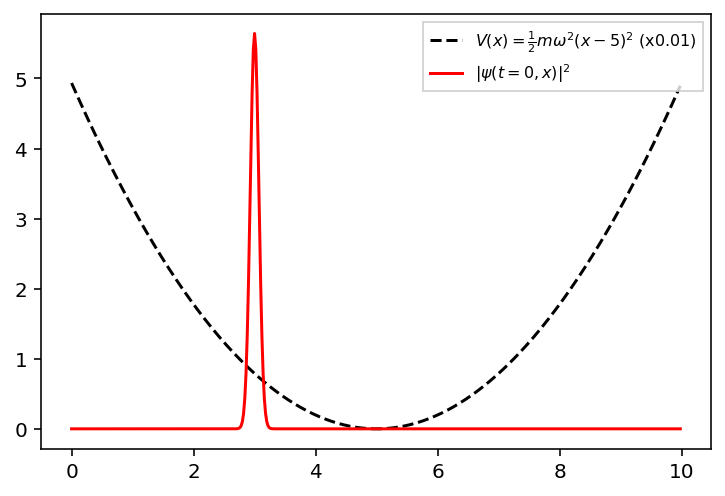

In [2]:
dx    = 0.02                       # spatial separation
x     = np.arange(0, 10, dx)       # spatial grid points

kx    = 0.1                        # wave number
m     = 1                          # mass
sigma = 0.1                        # width of initial gaussian wave-packet
x0    = 3.0                        # center of initial gaussian wave-packet

A = 1.0 / (sigma * np.sqrt(np.pi)) # normalization constant

# Initial Wavefunction
psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (2.0 * sigma**2)) * np.exp(1j * kx * x)


# Potential V(x)
x_Vmin = 5         # center of V(x)
T      = 1           # peroid of SHO 

omega = 2 * np.pi / T
k = omega**2 * m
V = 0.5 * k * (x - x_Vmin)**2


# Make a plot of psi0 and V 
plt.plot(x, V*0.01, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")
plt.plot(x, np.abs(psi0)**2, "r", label=r"$\vert\psi(t=0,x)\vert^2$")
plt.legend(loc=1, fontsize=8, fancybox=False)
print("Total Probability: ", np.sum(np.abs(psi0)**2)*dx)

## Laplace Operator (Finite Difference)

The 1-D Laplace operator $\nabla^2=\frac{\partial^2}{\partial x^2}$ can be expressed in terms of a banded matrix:

\begin{align}
\frac{\partial^2}{\partial x^2} y(x)
&= 
\frac{1}{dx} \left[ \frac{y_{n+1} - y_{n}}{dx} - \frac{y_{n} - y_{n-1}}{dx} \right]
\\
&=
\frac{y_{n+1} - 2 y_{n} + y_{n-1}}{(dx)^2} 
\\
&=
\frac{1}{(dx)^2}
\begin{pmatrix}
  -2  &  1  &  0  &  0 &  0 \\
   1  & -2  &  1  &  0 &  0 \\
   0  &  1  & -2  &  1 &  0 \\
   0  &  0  &  1  & -2 &  1 \\
   0  &  0  &  0  &  1 & -2 
\end{pmatrix}
\cdot
\begin{pmatrix}
   y_1   \\
   y_2   \\
   y_3   \\
   y_4   \\
   y_5  
\end{pmatrix}
\\
&\equiv
\mathbf{D2} \cdot \mathbf{y}
\end{align}

In [3]:
# Laplace Operator (Finite Difference)
D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2

In [4]:
D2.toarray()*dx**2

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [5]:
x.shape

(500,)

In [6]:
D2.shape

(500, 500)

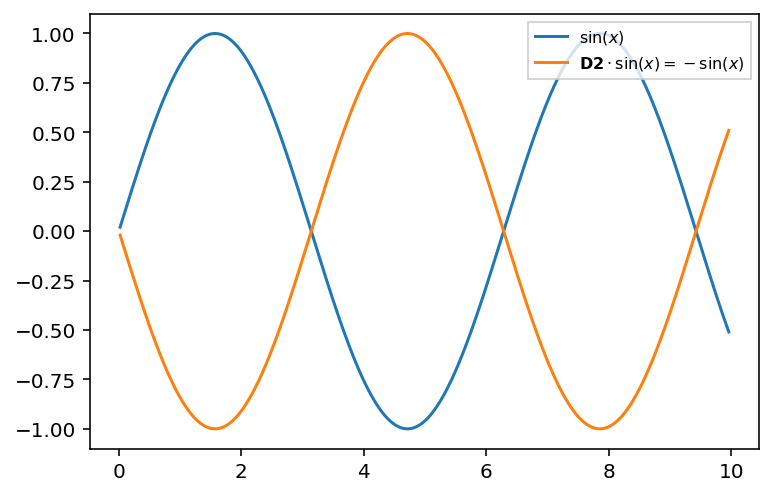

In [7]:
plt.plot(x[1:-1], np.sin(x)[1:-1], label=r"$\sin(x)$")
plt.plot(x[1:-1], D2.dot(np.sin(x))[1:-1], label=r"$\mathbf{D2} \cdot \sin(x) = -\sin(x)$")
plt.legend(loc=1, fontsize=8, fancybox=False)

## Solve Schrodinger Equation

Original 1-D Schrodinger equation: $-\frac{\hbar^2}{2m}\nabla^2\psi + V \psi = i\hbar\frac{\partial}{\partial t}\psi$


=> 
$$\psi_t \equiv \frac{\partial}{\partial t}\psi(t,x) = -i\left[-\frac{\hbar}{2m}\nabla^2\psi(t,x) + \frac{1}{\hbar} V(x) \psi(t,x)\right]$$

In [8]:
# RHS of Schrodinger Equation
hbar = 1
# hbar = 1.0545718176461565e-34
def psi_t(t, psi):
    return -1j * (- 0.5 * hbar / m * D2.dot(psi) + V / hbar * psi)

In [9]:
dt = 0.005  # time interval for snapshots
t0 = 0.0    # initial time
tf = 1.0    # final time
t_eval = np.arange(t0, tf, dt)  # recorded time shots

# Solve the Initial Value Problem
sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")

## Plotting

In [10]:
sol.y[:,0].shape

(500,)

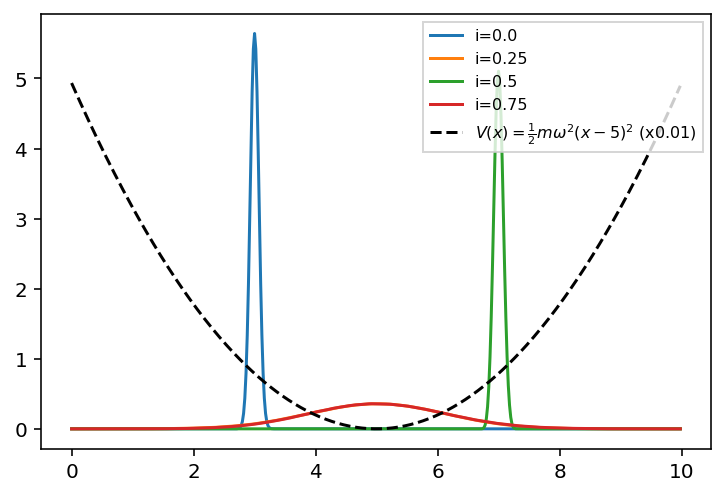

In [11]:
fig = plt.figure(figsize=(6, 4))
for i, t in enumerate(sol.t):
    if i%50==0:
        plt.plot(x, np.abs(sol.y[:,i])**2, label=f'i={i*dt}')             # Plot Wavefunctions
#     print(np.sum(np.abs(sol.y[:,i])**2)*dx)        # Print Total Probability (Should = 1)
plt.plot(x, V * 0.01, "k--", label=r"$V(x) = \frac{1}{2}m\omega^2 (x-5)^2$ (x0.01)")   # Plot Potential
plt.legend(loc=1, fontsize=8, fancybox=False)
fig.savefig('sho@2x.png')

## Animation

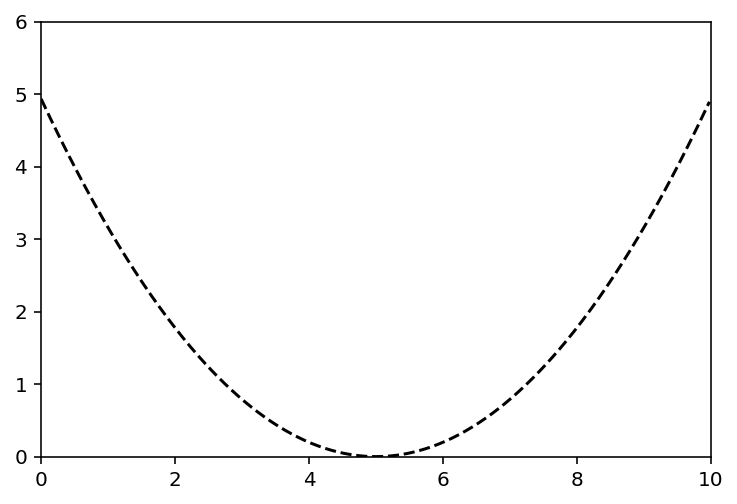

In [12]:
fig = plt.figure()
ax1 = plt.subplot(1,1,1)
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6)
title = ax1.set_title('')
line1, = ax1.plot([], [], "k--")
line2, = ax1.plot([], [])


def init():
    line1.set_data(x, V * 0.01)
    return line1,


def animate(i):
    line2.set_data(x, np.abs(sol.y[:,i])**2)
    title.set_text('Time = {0:1.3f}'.format(sol.t[i]))
    return line1,


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(sol.t), interval=50, blit=True)

In [ ]:
# Save the animation into a short video
#anim.save('sho.mp4', fps=15, extra_args=['-vcodec', 'libx264'], dpi=600)

In [ ]:
# Display the animation in the jupyter notebook
HTML(anim.to_jshtml())

# Extracting eigenvalues and eigenvectors from Operator
 $$-\frac{\hbar^2}{2m}\nabla^2\psi + V \psi  = E \psi$$

 So we are solving for:
 $$ \hat M \psi = E \psi$$


In [17]:
# Potential V(x)
x_Vmin = 5         # center of V(x)
omega = 1
hbar = 1
m = 1
k = omega**2 * m
V = 0.5 * k * (x - x_Vmin)**2

In [30]:
M = (- 0.5 * hbar / m) * D2 + V * np.eye(500)
M

matrix([[ 2512.5   , -1250.    ,     0.    , ...,     0.    ,     0.    ,
             0.    ],
        [-1250.    ,  2512.4002, -1250.    , ...,     0.    ,     0.    ,
             0.    ],
        [    0.    , -1250.    ,  2512.3008, ...,     0.    ,     0.    ,
             0.    ],
        ...,
        [    0.    ,     0.    ,     0.    , ...,  2512.2018, -1250.    ,
             0.    ],
        [    0.    ,     0.    ,     0.    , ..., -1250.    ,  2512.3008,
         -1250.    ],
        [    0.    ,     0.    ,     0.    , ...,     0.    , -1250.    ,
          2512.4002]])

In [38]:
E, eigenv = np.linalg.eig(M)

In [39]:
order = E.argsort()
E = E[order]
eigenv = eigenv[:,order]

In [40]:
xx = np.linspace(0,500,500)
Eteorica = 1/2 + xx

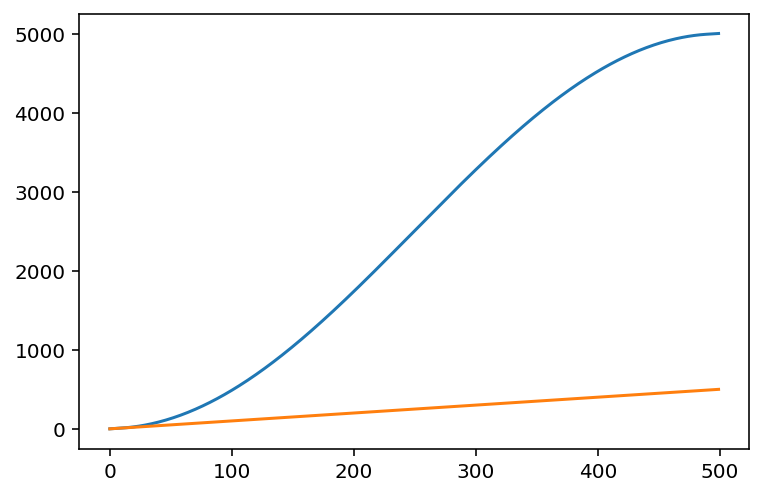

In [41]:
plt.plot(E)
plt.plot(Eteorica)

Observe the different eigenvectors, which are the states, the state of the system

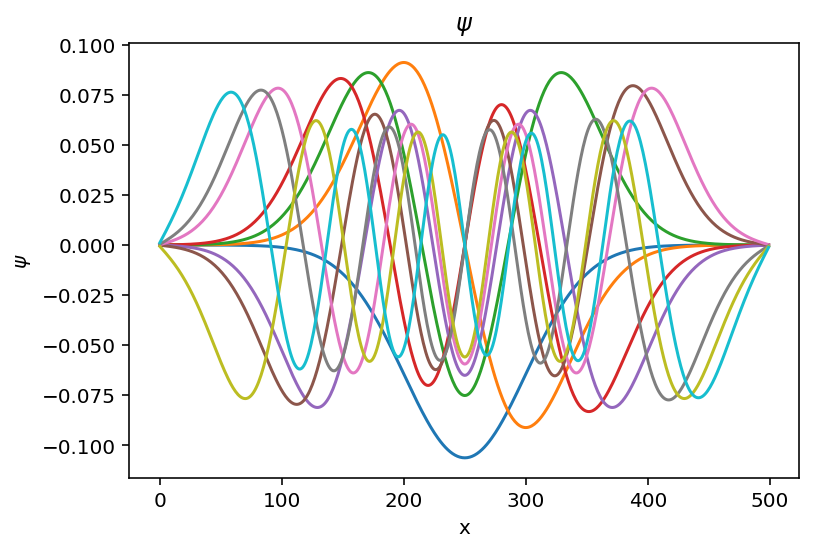

In [47]:
plt.title(r"$\psi$")
for EE in range(0,10):
    plt.plot(eigenv[:,EE], label=f'E = {EE}')
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.show()

We can see up to which the correct $E$ holds up to the theoric energy

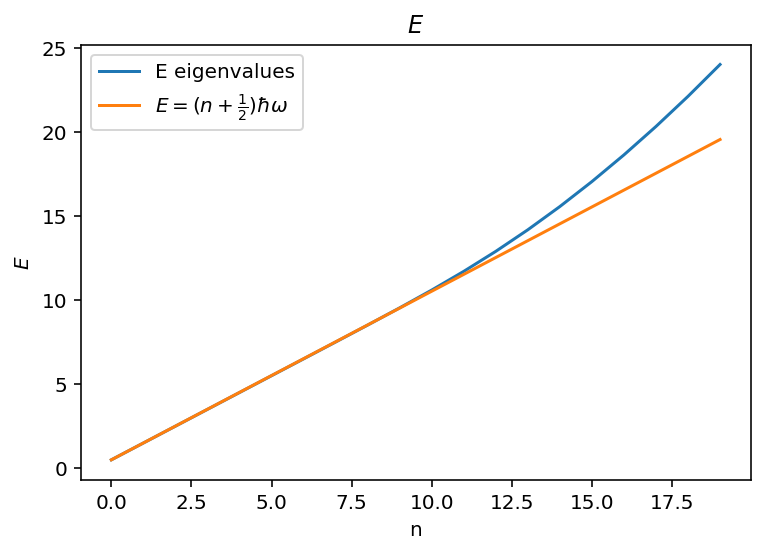

In [50]:
limite = 20

xx = np.linspace(0,500,500)
Eteorica = (1/2 + xx)* hbar * omega

plt.title(r"$E$")

plt.plot(E[:limite], label=f'E eigenvalues')
plt.plot(Eteorica[:limite], label=r'$E = (n + \frac{1}{2}) \hbar \omega$')

plt.legend()
plt.xlabel("n")
plt.ylabel(r"$E$")
plt.show()

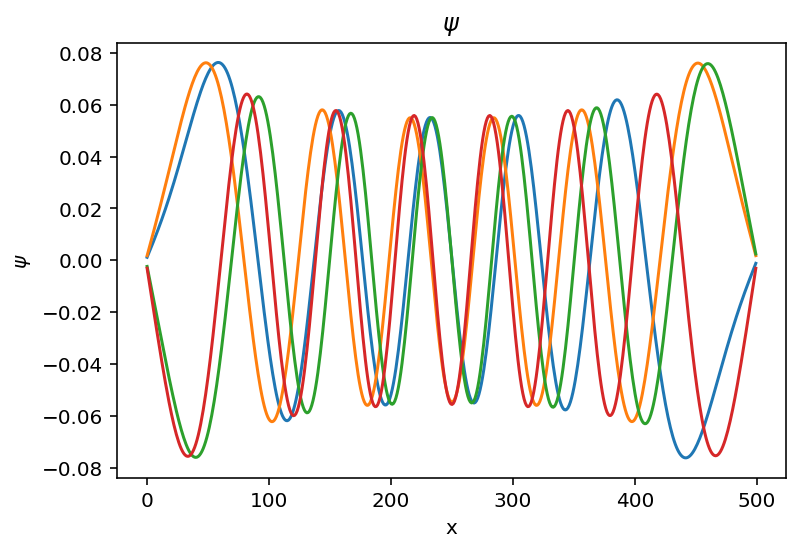

In [52]:
#what happens after the 10th
plt.title(r"$\psi$")
for EE in range(9,13):
    plt.plot(eigenv[:,EE], label=f'E = {EE}')
plt.xlabel("x")
plt.ylabel(r"$\psi$")
plt.show()